In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,mean_absolute_percentage_error
from tqdm import tqdm


In [13]:
with open('/home/f20222001/test-venv/UHI/Datasets_processed/inputs_36_extra_clean_10k.pkl', 'rb') as f, open('/home/f20222001/test-venv/UHI/Datasets_processed/targets_36_extra_clean_10k.pkl','rb') as t:
    inputs = pickle.load(f)
    targets = pickle.load(t)
# Shuffle before splitting (preserves alignment of X and y)
X_shuffled, y_shuffled = shuffle(inputs, targets, random_state=42)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X_shuffled, y_shuffled, test_size=0.2, random_state=42
)
# X_train, X_test, Y_train, Y_test = train_test_split(
#     X_train, Y_train, test_size=0.2, random_state=42
# )
X_train.shape

(496856, 36, 17)

In [14]:
# with open("inputs_small_train_36.pkl", "wb") as f:
#     pickle.dump(X_train, f)

# with open("inputs_small_test_36.pkl", "wb") as f:
#     pickle.dump(X_test, f)
# # Save targets
# with open("targets_small_train_36.pkl", "wb") as f:
#     pickle.dump(y_train, f)
# with open("targets_small_test_36.pkl", "wb") as f:
#     pickle.dump(y_test, f)

In [15]:
# with open("inputs_small_train_36.pkl", "rb") as f:
#     X_train = pickle.load(f)

# with open("inputs_small_test_36.pkl", "rb") as f:
#     X_test = pickle.load(f)
# # Save targets
# with open("targets_small_train_36.pkl", "rb") as f:
#     Y_train = pickle.load(f)
# with open("targets_small_test_36.pkl", "rb") as f:
#     Y_test = pickle.load(f)

In [16]:
print(torch.cuda.current_device())

2


In [17]:
torch.cuda.set_device(2)  

In [18]:
# Indexes of features to normalize
norm_idx = [0, 1, 2, 3] 

# Flatten for scaling
X_train_flat = X_train.reshape(-1, X_train.shape[2])
X_test_flat = X_test.reshape(-1, X_test.shape[2])

# Initialize a new array to hold the scaled data
X_train_scaled = X_train_flat.copy()
X_test_scaled = X_test_flat.copy()

scaler = StandardScaler()

# Fit and transform only the continuous columns
X_train_scaled[:, norm_idx] = scaler.fit_transform(X_train_flat[:, norm_idx])
X_test_scaled[:, norm_idx] = scaler.transform(X_test_flat[:, norm_idx])

# Reshape back to 3D
X_train = X_train_scaled.reshape(X_train.shape)
X_test = X_test_scaled.reshape(X_test.shape)

y_train_flat = Y_train.reshape(-1, 1)
y_test_flat = Y_test.reshape(-1, 1)

standard_scaler_y = StandardScaler()
y_train_scaled = standard_scaler_y.fit_transform(y_train_flat)
y_test_scaled = standard_scaler_y.transform(y_test_flat)

# Reshape back to original shape
Y_train = y_train_scaled.reshape(Y_train.shape)
Y_test = y_test_scaled.reshape(Y_test.shape)



In [19]:
X_train.shape

(496856, 36, 17)

In [20]:
X_train

array([[[-0.19186893,  2.449692  , -2.1372743 , ...,  0.        ,
          0.        ,  0.        ],
        [-0.4586669 ,  2.0545552 , -1.7503618 , ...,  0.        ,
          0.        ,  0.        ],
        [-1.2219061 ,  1.4900672 , -0.80864114, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.10057762,  0.30148962,  0.07203184, ...,  0.        ,
          0.        ,  0.        ],
        [-0.78597146, -0.06016689,  0.4819251 , ...,  0.        ,
          0.        ,  0.        ],
        [-1.4131583 , -0.06629609,  0.53357536, ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.5519089 , -0.5522327 ,  0.9763144 , ...,  0.        ,
          0.        ,  0.        ],
        [ 1.004651  , -0.6347799 ,  0.9935073 , ...,  0.        ,
          0.        ,  0.        ],
        [ 1.1789187 , -0.7051481 ,  1.1999577 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.22229975,  0.39034405,  0.5312093 , ...,  

In [21]:
Y_train.shape

(496856,)

In [22]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(Y_train, dtype=torch.float32))

test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(Y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)


In [23]:
device = torch.device("cuda")
device

device(type='cuda')

In [24]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=1536, num_layers=3, dropout=0.3):
        super(LSTMPredictor, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_size, 1)  # Output = scalar

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_len, hidden_size)
        last_time_step = lstm_out[:, -1, :]  # take the last time step's output
        out = self.fc(last_time_step)  # (batch_size, 1)
        return out.squeeze(1)  # final shape: (batch_size,)
    


  1%|          | 1/100 [00:58<1:36:54, 58.74s/it]

Epoch 1/100 - Train Loss: 0.09946806728839874


  2%|▏         | 2/100 [01:57<1:35:53, 58.71s/it]

Epoch 2/100 - Train Loss: 0.1084042638540268


  3%|▎         | 3/100 [02:56<1:35:01, 58.77s/it]

Epoch 3/100 - Train Loss: 0.13400715589523315


  4%|▍         | 4/100 [03:55<1:34:08, 58.84s/it]

Epoch 4/100 - Train Loss: 0.050998151302337646


  5%|▌         | 5/100 [04:54<1:33:10, 58.85s/it]

Epoch 5/100 - Train Loss: 0.035985976457595825


  6%|▌         | 6/100 [05:53<1:32:15, 58.89s/it]

Epoch 6/100 - Train Loss: 0.04578902944922447


  7%|▋         | 7/100 [06:51<1:31:17, 58.90s/it]

Epoch 7/100 - Train Loss: 0.055820219218730927


  8%|▊         | 8/100 [07:50<1:30:18, 58.90s/it]

Epoch 8/100 - Train Loss: 0.04605817422270775


  9%|▉         | 9/100 [08:49<1:29:20, 58.90s/it]

Epoch 9/100 - Train Loss: 0.1354118436574936


 10%|█         | 10/100 [09:48<1:28:21, 58.90s/it]

Epoch 10/100 - Train Loss: 0.05816907063126564


 11%|█         | 11/100 [10:47<1:27:21, 58.89s/it]

Epoch 11/100 - Train Loss: 0.07671251893043518


 12%|█▏        | 12/100 [11:46<1:26:21, 58.88s/it]

Epoch 12/100 - Train Loss: 0.05317967012524605


 13%|█▎        | 13/100 [12:45<1:25:22, 58.88s/it]

Epoch 13/100 - Train Loss: 0.1131967157125473


 14%|█▍        | 14/100 [13:44<1:24:22, 58.87s/it]

Epoch 14/100 - Train Loss: 0.0666104331612587


 15%|█▌        | 15/100 [14:42<1:23:23, 58.86s/it]

Epoch 15/100 - Train Loss: 0.04341284930706024


 16%|█▌        | 16/100 [15:41<1:22:24, 58.86s/it]

Epoch 16/100 - Train Loss: 0.03482131287455559


 17%|█▋        | 17/100 [16:40<1:21:25, 58.86s/it]

Epoch 17/100 - Train Loss: 0.050563596189022064


 18%|█▊        | 18/100 [17:39<1:20:25, 58.85s/it]

Epoch 18/100 - Train Loss: 0.08501086384057999


 19%|█▉        | 19/100 [18:38<1:19:27, 58.86s/it]

Epoch 19/100 - Train Loss: 0.047786545008420944


 20%|██        | 20/100 [19:37<1:18:28, 58.85s/it]

Epoch 20/100 - Train Loss: 0.030633272603154182


 21%|██        | 21/100 [20:36<1:17:27, 58.83s/it]

Epoch 21/100 - Train Loss: 0.07596715539693832


 22%|██▏       | 22/100 [21:34<1:16:29, 58.84s/it]

Epoch 22/100 - Train Loss: 0.03773700073361397


 23%|██▎       | 23/100 [22:33<1:15:29, 58.83s/it]

Epoch 23/100 - Train Loss: 0.05022401735186577


 24%|██▍       | 24/100 [23:32<1:14:31, 58.83s/it]

Epoch 24/100 - Train Loss: 0.020469387993216515


 25%|██▌       | 25/100 [24:31<1:13:30, 58.81s/it]

Epoch 25/100 - Train Loss: 0.01792512647807598


 26%|██▌       | 26/100 [25:30<1:12:31, 58.80s/it]

Epoch 26/100 - Train Loss: 0.02389645203948021


 27%|██▋       | 27/100 [26:28<1:11:32, 58.80s/it]

Epoch 27/100 - Train Loss: 0.03329089283943176


 28%|██▊       | 28/100 [27:27<1:10:32, 58.79s/it]

Epoch 28/100 - Train Loss: 0.040771033614873886


 29%|██▉       | 29/100 [28:26<1:09:33, 58.78s/it]

Epoch 29/100 - Train Loss: 0.02398267388343811


 30%|███       | 30/100 [29:25<1:08:34, 58.79s/it]

Epoch 30/100 - Train Loss: 0.04195604845881462


 31%|███       | 31/100 [30:23<1:07:35, 58.78s/it]

Epoch 31/100 - Train Loss: 0.026261618360877037


 32%|███▏      | 32/100 [31:22<1:06:36, 58.77s/it]

Epoch 32/100 - Train Loss: 0.04016214981675148


 33%|███▎      | 33/100 [32:21<1:05:36, 58.75s/it]

Epoch 33/100 - Train Loss: 0.025132259353995323


 34%|███▍      | 34/100 [33:20<1:04:37, 58.75s/it]

Epoch 34/100 - Train Loss: 0.02301301434636116


 35%|███▌      | 35/100 [34:18<1:03:37, 58.73s/it]

Epoch 35/100 - Train Loss: 0.027789201587438583


 36%|███▌      | 36/100 [35:17<1:02:39, 58.73s/it]

Epoch 36/100 - Train Loss: 0.029283542186021805


 37%|███▋      | 37/100 [36:16<1:01:40, 58.75s/it]

Epoch 37/100 - Train Loss: 0.016698196530342102


 38%|███▊      | 38/100 [37:15<1:00:42, 58.75s/it]

Epoch 38/100 - Train Loss: 0.02423337660729885


 39%|███▉      | 39/100 [38:13<59:43, 58.75s/it]  

Epoch 39/100 - Train Loss: 0.02878359705209732


 40%|████      | 40/100 [39:12<58:44, 58.74s/it]

Epoch 40/100 - Train Loss: 0.021764734759926796


 41%|████      | 41/100 [40:11<57:46, 58.75s/it]

Epoch 41/100 - Train Loss: 0.03702818602323532


 42%|████▏     | 42/100 [41:09<56:46, 58.72s/it]

Epoch 42/100 - Train Loss: 0.01682295650243759


 43%|████▎     | 43/100 [42:08<55:48, 58.74s/it]

Epoch 43/100 - Train Loss: 0.028246000409126282


 44%|████▍     | 44/100 [43:07<54:48, 58.72s/it]

Epoch 44/100 - Train Loss: 0.023671383038163185


 45%|████▌     | 45/100 [44:06<53:49, 58.72s/it]

Epoch 45/100 - Train Loss: 0.0233200341463089


 46%|████▌     | 46/100 [45:04<52:50, 58.71s/it]

Epoch 46/100 - Train Loss: 0.022716592997312546


 47%|████▋     | 47/100 [46:03<51:52, 58.72s/it]

Epoch 47/100 - Train Loss: 0.021644344553351402


 48%|████▊     | 48/100 [47:02<50:52, 58.70s/it]

Epoch 48/100 - Train Loss: 0.024024369195103645


 49%|████▉     | 49/100 [48:00<49:53, 58.70s/it]

Epoch 49/100 - Train Loss: 0.013515328988432884


 50%|█████     | 50/100 [48:59<48:55, 58.70s/it]

Epoch 50/100 - Train Loss: 0.022102590650320053


 51%|█████     | 51/100 [49:58<47:56, 58.71s/it]

Epoch 51/100 - Train Loss: 0.024798870086669922


 52%|█████▏    | 52/100 [50:57<46:57, 58.70s/it]

Epoch 52/100 - Train Loss: 0.012553353793919086


 53%|█████▎    | 53/100 [51:55<45:58, 58.69s/it]

Epoch 53/100 - Train Loss: 0.017801787704229355


 54%|█████▍    | 54/100 [52:54<45:00, 58.70s/it]

Epoch 54/100 - Train Loss: 0.019097382202744484


 55%|█████▌    | 55/100 [53:53<44:00, 58.68s/it]

Epoch 55/100 - Train Loss: 0.01234764326363802


 56%|█████▌    | 56/100 [54:51<43:02, 58.69s/it]

Epoch 56/100 - Train Loss: 0.012036086991429329


 57%|█████▋    | 57/100 [55:50<42:03, 58.68s/it]

Epoch 57/100 - Train Loss: 0.015899911522865295


 58%|█████▊    | 58/100 [56:49<41:04, 58.69s/it]

Epoch 58/100 - Train Loss: 0.009981352835893631


 59%|█████▉    | 59/100 [57:47<40:05, 58.67s/it]

Epoch 59/100 - Train Loss: 0.013413451611995697


 60%|██████    | 60/100 [58:46<39:07, 58.68s/it]

Epoch 60/100 - Train Loss: 0.01122598722577095


 61%|██████    | 61/100 [59:45<38:08, 58.67s/it]

Epoch 61/100 - Train Loss: 0.011929781176149845


 62%|██████▏   | 62/100 [1:00:43<37:08, 58.64s/it]

Epoch 62/100 - Train Loss: 0.013026120141148567


 63%|██████▎   | 63/100 [1:01:42<36:09, 58.64s/it]

Epoch 63/100 - Train Loss: 0.012586306780576706


 64%|██████▍   | 64/100 [1:02:40<35:10, 58.62s/it]

Epoch 64/100 - Train Loss: 0.011838842183351517


 65%|██████▌   | 65/100 [1:03:39<34:12, 58.64s/it]

Epoch 65/100 - Train Loss: 0.012778708711266518


 66%|██████▌   | 66/100 [1:04:38<33:13, 58.63s/it]

Epoch 66/100 - Train Loss: 0.010291186161339283


 67%|██████▋   | 67/100 [1:05:36<32:14, 58.63s/it]

Epoch 67/100 - Train Loss: 0.013150369748473167


 68%|██████▊   | 68/100 [1:06:35<31:15, 58.61s/it]

Epoch 68/100 - Train Loss: 0.012011680752038956


 69%|██████▉   | 69/100 [1:07:34<30:17, 58.62s/it]

Epoch 69/100 - Train Loss: 0.010427172295749187


 70%|███████   | 70/100 [1:08:32<29:18, 58.61s/it]

Epoch 70/100 - Train Loss: 0.008026853203773499


 71%|███████   | 71/100 [1:09:31<28:19, 58.61s/it]

Epoch 71/100 - Train Loss: 0.010549359954893589


 72%|███████▏  | 72/100 [1:10:29<27:20, 58.60s/it]

Epoch 72/100 - Train Loss: 0.015381411649286747


 73%|███████▎  | 73/100 [1:11:28<26:22, 58.61s/it]

Epoch 73/100 - Train Loss: 0.010805602185428143


 74%|███████▍  | 74/100 [1:12:27<25:23, 58.61s/it]

Epoch 74/100 - Train Loss: 0.007650548592209816


 75%|███████▌  | 75/100 [1:13:25<24:25, 58.62s/it]

Epoch 75/100 - Train Loss: 0.01051273662596941


 76%|███████▌  | 76/100 [1:14:24<23:26, 58.61s/it]

Epoch 76/100 - Train Loss: 0.01503652986139059


 77%|███████▋  | 77/100 [1:15:22<22:27, 58.61s/it]

Epoch 77/100 - Train Loss: 0.016814028844237328


 78%|███████▊  | 78/100 [1:16:21<21:29, 58.60s/it]

Epoch 78/100 - Train Loss: 0.01079960260540247


 79%|███████▉  | 79/100 [1:17:20<20:30, 58.59s/it]

Epoch 79/100 - Train Loss: 0.010816693305969238


 80%|████████  | 80/100 [1:18:18<19:32, 58.60s/it]

Epoch 80/100 - Train Loss: 0.0067550186067819595


 81%|████████  | 81/100 [1:19:17<18:33, 58.60s/it]

Epoch 81/100 - Train Loss: 0.0076843914575874805


 82%|████████▏ | 82/100 [1:20:15<17:34, 58.58s/it]

Epoch 82/100 - Train Loss: 0.010713290423154831


 83%|████████▎ | 83/100 [1:21:14<16:35, 58.56s/it]

Epoch 83/100 - Train Loss: 0.006334947422146797


 84%|████████▍ | 84/100 [1:22:12<15:37, 58.57s/it]

Epoch 84/100 - Train Loss: 0.007150259334594011


 85%|████████▌ | 85/100 [1:23:11<14:38, 58.55s/it]

Epoch 85/100 - Train Loss: 0.009006064385175705


 86%|████████▌ | 86/100 [1:24:09<13:39, 58.55s/it]

Epoch 86/100 - Train Loss: 0.008792982436716557


 87%|████████▋ | 87/100 [1:25:08<12:40, 58.53s/it]

Epoch 87/100 - Train Loss: 0.039454419165849686


 88%|████████▊ | 88/100 [1:26:06<11:42, 58.52s/it]

Epoch 88/100 - Train Loss: 0.013379474170506


 89%|████████▉ | 89/100 [1:27:05<10:43, 58.50s/it]

Epoch 89/100 - Train Loss: 0.009127141907811165


 90%|█████████ | 90/100 [1:28:03<09:45, 58.51s/it]

Epoch 90/100 - Train Loss: 0.008322603069245815


 91%|█████████ | 91/100 [1:29:02<08:46, 58.51s/it]

Epoch 91/100 - Train Loss: 0.009471863508224487


 92%|█████████▏| 92/100 [1:30:00<07:48, 58.50s/it]

Epoch 92/100 - Train Loss: 0.0087729562073946


 93%|█████████▎| 93/100 [1:30:59<06:49, 58.50s/it]

Epoch 93/100 - Train Loss: 0.007941175252199173


 94%|█████████▍| 94/100 [1:31:57<05:50, 58.50s/it]

Epoch 94/100 - Train Loss: 0.00794420950114727


 95%|█████████▌| 95/100 [1:32:56<04:52, 58.51s/it]

Epoch 95/100 - Train Loss: 0.006541689392179251


 96%|█████████▌| 96/100 [1:33:54<03:53, 58.48s/it]

Epoch 96/100 - Train Loss: 0.012453604489564896


 97%|█████████▋| 97/100 [1:34:53<02:55, 58.49s/it]

Epoch 97/100 - Train Loss: 0.008419807069003582


 98%|█████████▊| 98/100 [1:35:51<01:56, 58.49s/it]

Epoch 98/100 - Train Loss: 0.010922719724476337


 99%|█████████▉| 99/100 [1:36:50<00:58, 58.47s/it]

Epoch 99/100 - Train Loss: 0.030726030468940735


100%|██████████| 100/100 [1:37:48<00:00, 58.69s/it]

Epoch 100/100 - Train Loss: 0.0063679637387394905


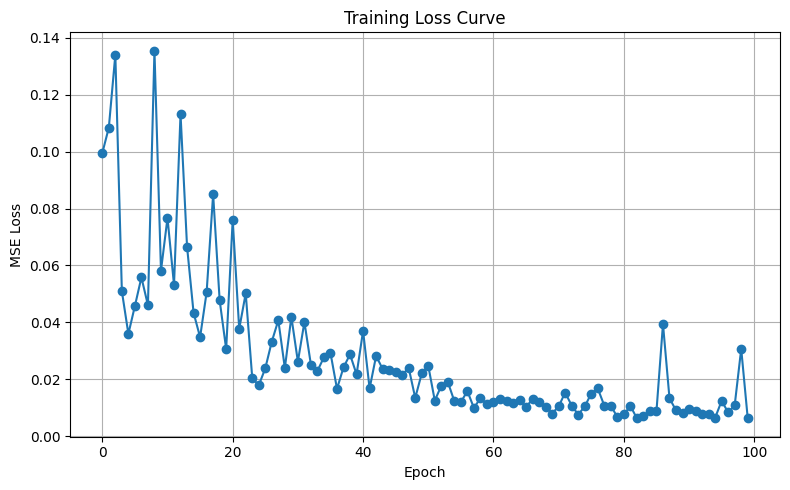

In [25]:
input_size = X_train.shape[2]  # num_features per timestep
model = LSTMPredictor(input_size=input_size)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
train_losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        #print(batch_x.shape)
        #print(batch_y.shape)
        # Forward
        preds = model(batch_x)  # shape: (batch_size,)
        #print(preds.shape)
        loss = criterion(preds, batch_y)
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {loss.item()}")
    train_losses.append(loss.item())
plt.figure(figsize=(8, 5))
plt.plot(np.arange(num_epochs),train_losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        preds = model(batch_x)
        
        y_true.extend(batch_y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true).reshape(-1, 1)
y_pred = np.array(y_pred).reshape(-1, 1)

# Unnormalize using RobustScaler
y_true = standard_scaler_y.inverse_transform(y_true)
y_pred = standard_scaler_y.inverse_transform(y_pred)

# Flatten back
y_true = y_true.flatten()
y_pred = y_pred.flatten()

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape=mean_absolute_percentage_error(y_true, y_pred)
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test R²:   {r2:.4f}")
print(f"Test MAPE:   {mape:.4f}")

Test MSE:  2.9406
Test RMSE: 1.7148
Test MAE:  0.9483
Test R²:   0.9623
Test MAPE:   0.0371
